### Dependencies

In [1]:
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import albumentations as albu
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

!pip install segmentation-models
import segmentation_models as sm

Using TensorFlow backend.


     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])
test['set'] = 'test'

display(X_train.head())

Compete set samples: 22184
Train samples:  4436
Validation samples:  1110
Test samples: 14792


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,set
0,c9629d8.jpg,NaN,1082202 658 1083602 658 1085002 658 1086402 65...,1134924 476 1136324 476 1137724 476 1139124 47...,1674 417 3074 417 4474 417 5874 417 7274 417 8...,train
1,e8e25ab.jpg,239 463 1639 463 3039 463 4439 463 5839 463 72...,1029006 350 1030406 350 1031806 350 1033206 35...,NaN,5606 574 7006 574 8406 574 9806 574 11206 574 ...,train
2,31c1874.jpg,959762 410 961162 410 962562 410 963962 410 96...,751962 1228 753362 1228 754762 1228 756162 122...,NaN,NaN,train
3,a396614.jpg,NaN,NaN,17941 239 19341 239 20741 239 22141 239 23541 ...,3030 665 4430 665 5830 665 7230 665 8574 1226 ...,train
4,560dedf.jpg,6555 444 7955 444 8437 897 9355 444 9837 897 1...,NaN,NaN,1409 644 2809 644 4209 644 5609 644 7009 644 8...,train


# Model parameters

In [3]:
BACKBONE = 'resnet18'
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 3e-4
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
LR_WARMUP_EPOCHS = 1
WARMUP_BATCHES = (LR_WARMUP_EPOCHS * len(X_train)) // BATCH_SIZE
model_path = '../working/uNet_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)

In [4]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.15),
                             albu.ShiftScaleRotate(rotate_limit=0, p=0.2)
                            ])

### Auxiliary functions

In [5]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['image']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, train_base_path, train_images_dest_path)
        if item_set == 'validation':
            preprocess_image(image_id, train_base_path, validation_images_dest_path)
        if item_set == 'test':
            preprocess_image(image_id, test_base_path, test_images_dest_path)
            
def get_metrics(model, df, df_images_dest_path, min_mask_sizes, set_name='Complete set'):
    column_names = ['Fish', 'Flower', 'Gravel', 'Sugar', set_name]
    index_name = ['Dice Coeff']
    dice = np.zeros((1, N_CLASSES))
    dice_post = np.zeros((1, N_CLASSES))
    
    for i in range(0, df.shape[0], 500):
        batch_score = []
        batch_score_post = []
        batch_idx = list(range(i, min(df.shape[0], i + 500)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      base_path=df_images_dest_path,
                      df=batch_set,
                      target_df=train,
                      batch_size=len(batch_set), 
                      reshape=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      random_state=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)

        for index in range(len(batch_idx)):
            class_score = []
            class_score_post = []
            sample_mask = y[index, ]
            sample_pred = preds[index, ]
            for class_index in range(N_CLASSES):
                label_class = sample_mask[..., class_index]
                pred_class = sample_pred[..., class_index]
                pred_class_post = post_process(pred_class, min_size=min_mask_sizes[class_index])
                dice_score = dice_coefficient(pred_class, label_class)
                dice_score_post = dice_coefficient(pred_class_post, label_class)
                if math.isnan(dice_score):
                    dice_score = 0.0
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            batch_score.append(class_score)
            batch_score_post.append(class_score_post)
        dice += np.mean(batch_score, axis=0) * ratio
        dice_post += np.mean(batch_score_post, axis=0) * ratio

    dice_class = np.mean(dice, axis=0)
    dice = np.mean(dice_class, axis=0)
    metrics = np.append(dice_class,  dice)
    metrics = pd.DataFrame(metrics.reshape(1, metrics.shape[0]), columns=column_names, index=index_name)
    
    dice_class_post = np.mean(dice_post, axis=0)
    dice_post = np.mean(dice_class_post, axis=0)
    metrics_post = np.append(dice_class_post, dice_post)
    metrics_post = pd.DataFrame(metrics_post.reshape(1, metrics_post.shape[0]), columns=column_names, index=index_name)
    
    return metrics, metrics_post

def plot_metrics(history):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 14))
    
    ax1.plot(history['loss'], label='Train loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')

    ax2.plot(history['dice_coef'], label='Train Dice coefficient')
    ax2.plot(history['val_dice_coef'], label='Validation Dice coefficient')
    ax2.legend(loc='best')
    ax2.set_title('Dice coefficient')

    ax3.plot(history['score'], label='Train F-Score')
    ax3.plot(history['val_score'], label='Validation F-Score')
    ax3.legend(loc='best')
    ax3.set_title('F-Score')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()
    
def pre_process_set(df, preprocess_fn):
    n_cpu = mp.cpu_count()
    df_n_cnt = df.shape[0]//n_cpu
    pool = mp.Pool(n_cpu)
    
    dfs = [df.iloc[df_n_cnt*i:df_n_cnt*(i+1)] for i in range(n_cpu)]
    dfs[-1] = df.iloc[df_n_cnt*(n_cpu-1):]
    res = pool.map(preprocess_fn, [x_df for x_df in dfs])
    pool.close()
    
class WarmUpLearningRateScheduler(Callback):
    def __init__(self, warmup_batches, init_lr, verbose=0):
        """
        Constructor for warmup learning rate scheduler
        :param warmup_batches {int}: Number of batch for warmup.
        :param init_lr {float}: Learning rate after warmup.
        :param verbose {int}: 0: quiet, 1: update messages. (default: {0})
        """
        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.batch_count = self.batch_count + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count * self.init_lr / self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %02d: WarmUpLearningRateScheduler setting learning rate to %s.' % (self.batch_count + 1, lr))
                
class RAdam(optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False, **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t > 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Pre-process data

In [6]:
train_base_path = '../input/understanding_cloud_organization/train_images/'
test_base_path = '../input/understanding_cloud_organization/test_images/'
train_images_dest_path = 'base_dir/train_images/'
validation_images_dest_path = 'base_dir/validation_images/'
test_images_dest_path = 'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_images_dest_path)
os.makedirs(validation_images_dest_path)
os.makedirs(test_images_dest_path)

# Pre-procecss train set
pre_process_set(X_train, preprocess_data)

# Pre-procecss validation set
pre_process_set(X_val, preprocess_data)

# Pre-procecss test set
pre_process_set(test, preprocess_data)

### Data generator

In [7]:
class DataGenerator(Sequence):
    def __init__(self, df, target_df=None, mode='fit', base_path=train_images_dest_path,
                 batch_size=BATCH_SIZE, n_channels=CHANNELS, reshape=(HEIGHT, WIDTH), 
                 n_classes=N_CLASSES, random_state=seed, shuffle=True, preprocessing=None, augmentation=None):
        
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.list_IDs = self.df.index
        self.random_state = random_state
        self.mask_shape = (1400, 2100)
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].loc[ID]
            img_path = self.base_path + im_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.preprocessing:
                img = self.preprocessing(img)
                
            img = img.astype(np.float32) / 255.
            
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == im_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.reshape)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def __random_transform(self, img, masks):
        composed = self.augmentation(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
train_generator = DataGenerator(
                  base_path=train_images_dest_path,
                  df=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  random_state=seed)

valid_generator = DataGenerator(
                  base_path=validation_images_dest_path,
                  df=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  random_state=seed)

# Model

In [8]:
model = sm.Unet(encoder_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
warmup_lr = WarmUpLearningRateScheduler(WARMUP_BATCHES, LEARNING_RATE)

loss = sm.losses.bce_dice_loss
metric_list = [dice_coef, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop, warmup_lr]
optimizer = RAdam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer, loss=loss, metrics=metric_list)
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 240, 64) 0           block1_conv2[0][0]               
____________________________________________

In [9]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15
 - 282s - loss: 1.5672 - dice_coef: 0.2372 - score: 0.1803 - val_loss: 1.5239 - val_dice_coef: 0.2460 - val_score: 0.1855
Epoch 2/15
 - 263s - loss: 1.4017 - dice_coef: 0.2449 - score: 0.1784 - val_loss: 1.3644 - val_dice_coef: 0.2499 - val_score: 0.1809
Epoch 3/15
 - 279s - loss: 1.2580 - dice_coef: 0.2835 - score: 0.1911 - val_loss: 1.2391 - val_dice_coef: 0.2570 - val_score: 0.1640
Epoch 4/15
 - 273s - loss: 1.1536 - dice_coef: 0.3479 - score: 0.2134 - val_loss: 1.2463 - val_dice_coef: 0.2778 - val_score: 0.1488
Epoch 5/15
 - 279s - loss: 1.0987 - dice_coef: 0.3974 - score: 0.2332 - val_loss: 1.2086 - val_dice_coef: 0.3731 - val_score: 0.2073
Epoch 6/15
 - 279s - loss: 1.0686 - dice_coef: 0.4314 - score: 0.2470 - val_loss: 1.1407 - val_dice_coef: 0.4298 - val_score: 0.2416
Epoch 7/15
 - 277s - loss: 1.0513 - dice_coef: 0.4527 - score: 0.2544 - val_loss: 1.1364 - val_dice_coef: 0.4308 - val_score: 0.2196
Epoch 8/15
 - 267s - loss: 1.0429 - dice_coef: 0.4646 - score: 0.2591

## Model loss graph

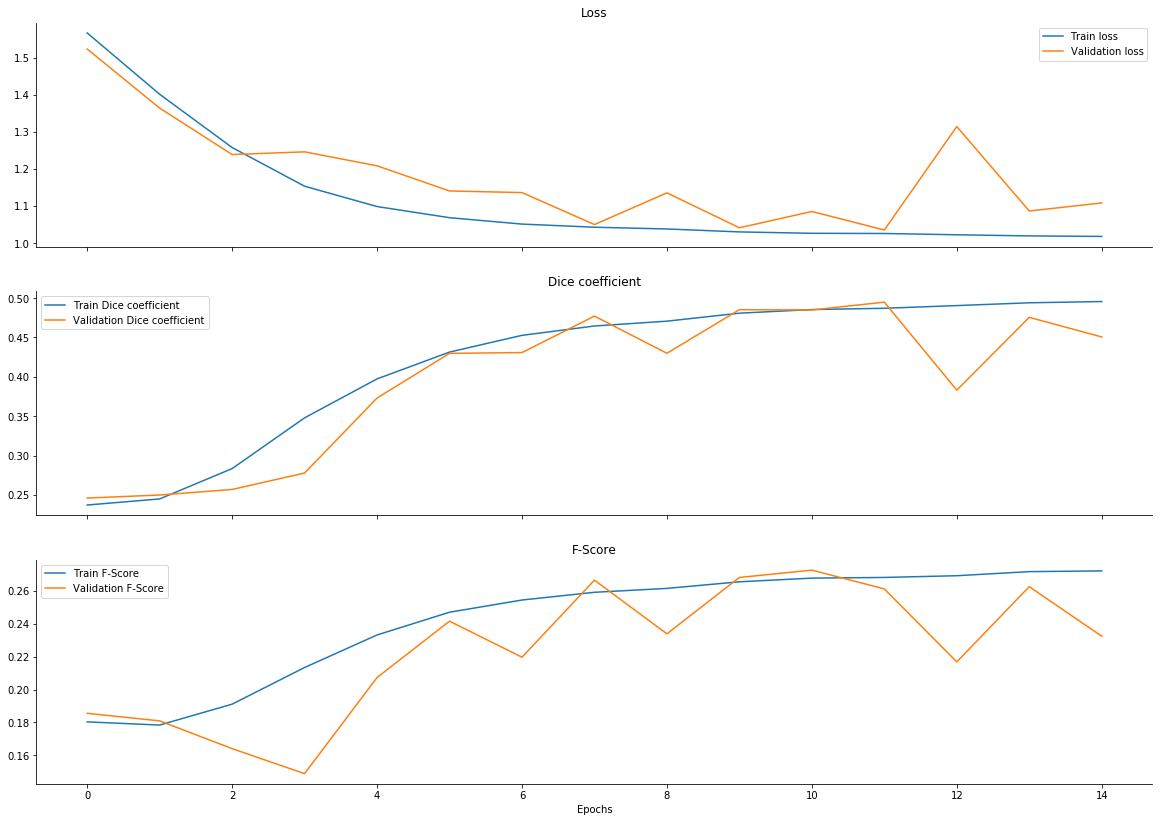

In [10]:
plot_metrics(history)

# Mask size tunning

In [11]:
mask_grid = [500, 1000, 5000, 7500, 10000, 15000]
class_names = ['Fish', 'Flower', 'Gravel', 'Sugar', 'Complete']
score = np.zeros((N_CLASSES, len(mask_grid)))
best_masks = []

for i in range(0, X_val.shape[0], 500):
    batch_score = []
    batch_idx = list(range(i, min(X_val.shape[0], i + 500)))
    batch_set = X_val[batch_idx[0]: batch_idx[-1]+1]
    ratio = len(batch_set) / len(X_val)
    
    generator = DataGenerator(
                  base_path=validation_images_dest_path,
                  df=batch_set,
                  target_df=train,
                  batch_size=len(batch_set), 
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  random_state=seed,
                  mode='fit',
                  shuffle=False)
    
    x, y = generator.__getitem__(0)
    preds = model.predict(x)

    for class_index in range(N_CLASSES):
        class_score = []
        label_class = y[..., class_index]
        pred_class = preds[..., class_index]
        for mask_size in mask_grid:
            mask_score = []
            for index in range(len(batch_idx)):
                label_mask = label_class[index, ]
                pred_mask = pred_class[index, ]
                pred_mask = post_process(pred_mask, min_size=mask_size)
                dice_score = dice_coefficient(pred_mask, label_mask)
                if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                    dice_score = 1.
                mask_score.append(dice_score)
            class_score.append(np.mean(mask_score))
        batch_score.append(class_score)
    score += np.asarray(batch_score) * ratio

set_score = np.mean(score, axis=0)
metrics = np.append(score, set_score.reshape(1, set_score.shape[0]), axis=0)
display(pd.DataFrame(metrics, columns=mask_grid, index=class_names))

for class_index in range(N_CLASSES):
    pm = score[class_index].argmax()
    best_mask, best_score = mask_grid[pm], score[class_index][pm].item()
    best_masks.append(best_mask)
    print('%s: mask size=%s, Dice=%.3f' % (class_names[class_index], best_mask, best_score))

,500,1000,5000,7500,10000,15000
Fish,0.448601,0.466137,0.525428,0.546115,0.561897,0.583869
Flower,0.625106,0.636577,0.677223,0.696351,0.703994,0.726300
Gravel,0.375889,0.379246,0.410431,0.429785,0.450449,0.497437
Sugar,0.431876,0.433644,0.432397,0.423742,0.410100,0.390500
Complete,0.470368,0.478901,0.511370,0.523998,0.531610,0.549526


Fish: mask size=15000, Dice=0.584
Flower: mask size=15000, Dice=0.726
Gravel: mask size=15000, Dice=0.497
Sugar: mask size=1000, Dice=0.434


# Model evaluation

## Without post processing

In [12]:
# Train metrics
train_metrics, train_metrics_post = get_metrics(model, X_train, train_images_dest_path, best_masks, 'Validation')
display(train_metrics)

# Validation metrics
validation_metrics, validation_metrics_post = get_metrics(model, X_val, validation_images_dest_path, best_masks, 'Validation')
display(validation_metrics)

,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,0.214849,0.196679,0.218628,0.24897,0.219781


,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,0.21368,0.192165,0.219514,0.248852,0.218553


## With post processing

In [13]:
display(train_metrics_post)
display(validation_metrics_post)

,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,NaN,NaN,NaN,NaN,NaN


,Fish,Flower,Gravel,Sugar,Validation
Dice Coeff,NaN,NaN,NaN,NaN,NaN


# Apply model to test set

In [14]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      base_path=test_images_dest_path,
                      df=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      reshape=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      random_state=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###

        ### Post procecssing 2
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, min_size=10000)
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_10000'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

### Regular submission

In [15]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,17 320 367 320 712 329 1058 336 1405 342 1754 ...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,112819 2 113167 3 113519 1 113869 1 114219 1 1...


### Submission with post processing

In [16]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,17 320 367 320 712 329 1058 336 1405 342 1754 ...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


In [17]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post_10000']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post_10000.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,17 320 367 320 712 329 1058 336 1405 342 1754 ...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


In [18]:
# Cleaning created directories
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)